# EEG Problem Set: Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import set_log_level
set_log_level(verbose=False)
%matplotlib inline

This assignment will consist of 3 parts:
- Part 1: ERP analysis
- Part 2: Time-frequency analysis
- Part 3: Experimental design question

# Part 1
## Instructions

In this problem set, you will be performing an ERP analysis and time-frequency analysis on a preprocessed dataset. First let's describe the task in greater detail. 

This experiment is based on the oddball paradigm used in [Luck et al., (2009)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8986.2009.00817.x). In the oddball paradigm, a letter or digit was presented every 1100-1500 ms. Subjects were instructed to press a button with one hand for digits and with the other hand for letters. For a given trial block, either the letters or the digits were rare (20%) and the other category was frequent (80%). The stimulus category (digits or letters), the probability (80% or 20%) and the hand used for response (left or right) were counterbalanced, leading to 8 experimental conditions. The probability manipulation was designed to isolate the probability-sensitive P300 component. Different event codes were used for the digits when they were rare (`20_Dig_L` for response with left hand, `20_Dig_R` for response with right), the digits when they were frequent (`80_Dig_L`, `80_Dig_R`), the letters when they were rare (`20_Let_L`, `20_Let_R`), and the letters when they were frequent (`80_Let_L`, `80_Let_R`). These event codes are summarized below:

|Left/Right|Rare|Frequent|
|---|---|---|
|Digits|20_Dig_L/20_Dig_R|80_Dig_L/80_Dig_R|
|Letters|20_Let_L/20_Let_R|80_Let_L/80_Let_R|

The P300 is a neural marker of surprise. As such, we expect a larger P300 during the rare trials than for the frequent trials. In this notebook, you will analyze the difference (if any) in P300s between conditions. Specifically, you will (1a) perform permutation testing, and (1b) visualize the evoked potentials. After this, you will (2) do a time-frequency analysis to identify a signature of conflict in the theta (4-8 Hz) band.

We've included the script used for preprocessing (`eeg-preprocessing.ipynb`) and an inspector (`eeg-visualization.ipynb`) if you'd like to take a closer look at the data.

Here is a visualization of the events in the experiment, using the raw data:

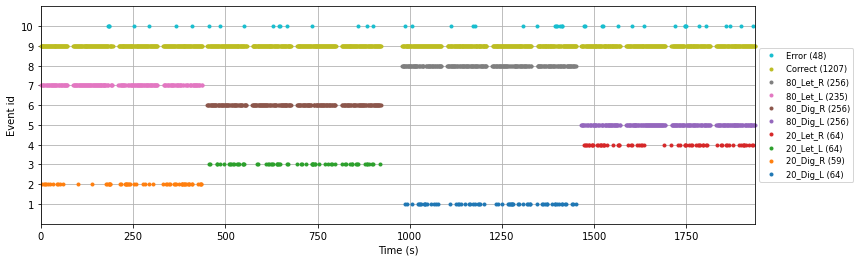

In [2]:
from mne.viz import plot_events
from mne.io import read_raw_fif
from mne import events_from_annotations

## Gather events.
raw = read_raw_fif('sub-01_task-digitsymbol_preproc_raw.fif')
events, event_id = events_from_annotations(read_raw_fif(
    'sub-01_task-digitsymbol_preproc_raw.fif', preload=False, verbose=False))

## Plot the events.
fig, ax = plt.subplots(1,1,figsize=(16,4))
fig = plot_events(events, raw.info['sfreq'], raw.first_samp, event_id=event_id, axes=ax);

We begin by loading in the epoched data.

In [4]:
from mne import read_epochs
from mne import Epochs, pick_types

# data = read_raw_fif('sub-01_task-digitsymbol_preproc_raw.fif')

# tmin = -.2
# tmax = .6
# baseline = (None, -0.1)
# reject = {'eeg': 100e-6}


# picks = pick_types(data.info, meg=False, eeg=True)
# epochs = Epochs(data, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=baseline,
#                 picks=picks, reject=reject, preload=True, verbose=False)

# print(epochs)

# epochs = epochs.crop(tmin=-0.1)


# epochs.drop_bad()
# print(epochs)


## Load epochs.
epochs = read_epochs('sub-01_task-digitsymbol-epo.fif', preload=True, verbose=False)
print(epochs)

<EpochsFIF |  1263 events (all good), -0.2 - 1 sec, baseline -0.2 – 0 sec, ~88.1 MB, data loaded,
 '20_Dig_R': 60
 '80_Let_L': 253
 '80_Dig_R': 254
 '20_Let_L': 64
 '80_Let_R': 251
 '20_Dig_L': 63
 '80_Dig_L': 254
 '20_Let_R': 64>


## 1a: Event Related Potential Analysis

In the following, you will look to find the P300 in the evoked potentials of each condition.

### Evoked Potentials

First, make two evoked potentials:
- *frequent*: an average of all the frequent (80) trials, collapsing over symbol and hand.
- *rare*: an average of all the rare (20) trials, collapsing over symbol and hand.

In [30]:
from mne import grand_average

averages = epochs.average(by_event_type=True)
rare = grand_average([x for x in averages if '20' in x.comment])
frequent = grand_average([x for x in averages if '80' in x.comment])

### Compare Evoked Potentials
Using `mne.viz.plot_evoked_topo`, plot a comparison of all the evoked potentials across the scalp.

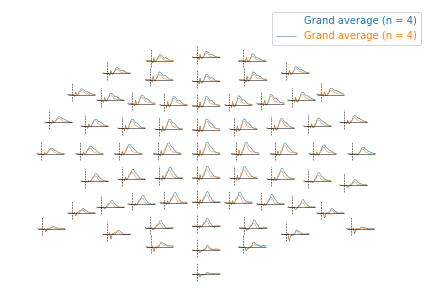

In [31]:
from mne.viz import plot_evoked_topo

plot_evoked_topo(evoked=[rare, frequent]);

**Q**: Is there an obvious P300?

> &nbsp; Yes

**Q**: If there is a P300, is it prominent everywhere?

> &nbsp; It seems to be less prominent near the edges of the scalp.

### Topographic Plots
Make topographic plots for the **difference wave**  Remember that the P300 should start around 300 ms and persist for many hundreds of milliseconds.

rare


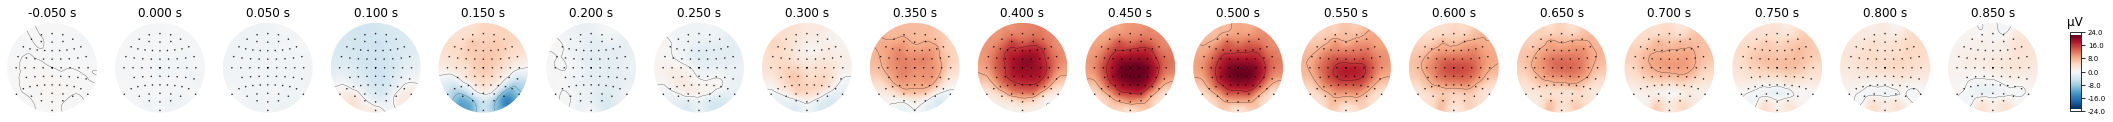

frequent


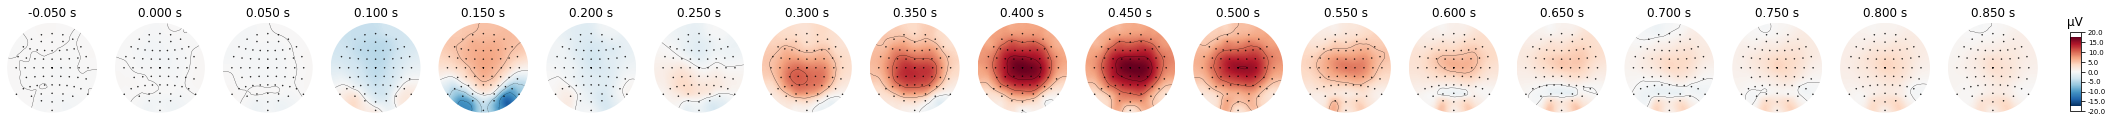

difference wave


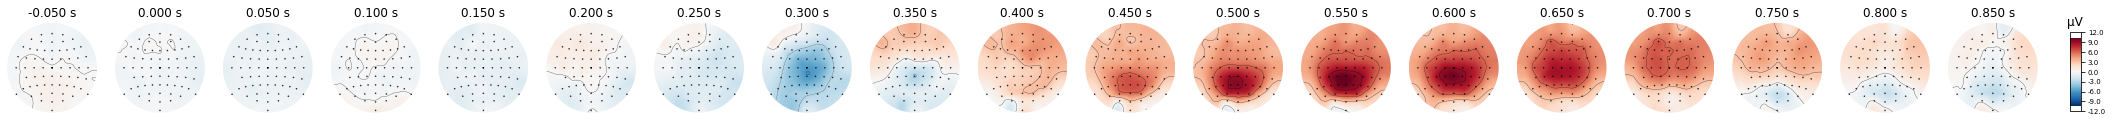

In [34]:
from mne import combine_evoked

print('rare')
rare.plot_topomap(times=np.arange(-0.05,0.9,0.05));
print('frequent')
frequent.plot_topomap(times=np.arange(-0.05,0.9,0.05));
print('difference wave')
combine_evoked([rare,frequent], [1,-1]).plot_topomap(times=np.arange(-0.05,0.9,0.05));

**Q**: If present, when is the P300 most prominent?

> &nbsp; It is most prominant around 500 - 650 ms (although it starts earlier than that)

**Q**: If present, where is the P300 most prominent?

> &nbsp; Initially in the frontal areas, then it lateralizes to the right hemisphere a bit, then to parietal regions.

## 1b: Replication + Permutation Testing

In this final step, we will formalize our analysis by replicating and extending Figure 2 from [Luck et al., (2009)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8986.2009.00817.x). To do so, we will perform permutation testing, testing for differences in the amplitude of the P300 between conditions across three sets of channels.

First, make two separate epoch objects:
- *frequent*: all the frequent (80)
- *rare*: all the rare (20) trials

In [35]:
rare_epochs = epochs[['80_Dig_R','80_Dig_L','80_Let_L','80_Let_L']]
frequent_epochs = epochs[['20_Dig_R','20_Dig_L','20_Let_L','20_Let_L']]

Next, find the corresponding indices for the following sets of channels. Find the indices using `mne.pick_channels`. 
- frontal: F1, Fz, F2
- central: C3, Cz, C4
- parietal: P3, Pz, P4

In [36]:
frontal = ['F1', 'Fz', 'F2']
central = ['C3', 'Cz', 'C4']
parietal = ['P3', 'Pz', 'P4']

Following the permutation testing code presented in the `eeg-02` demo, write a *for loop* that performs the following for each channel set:

1. Extracts the trials by channel set and condition (frequent, rare).
2. Average over the channels.
3. Performs permutation testing with 1024 permutations.
4. Plots the evoked potential (i.e. average over trials) per condition and highlights significant clusters.

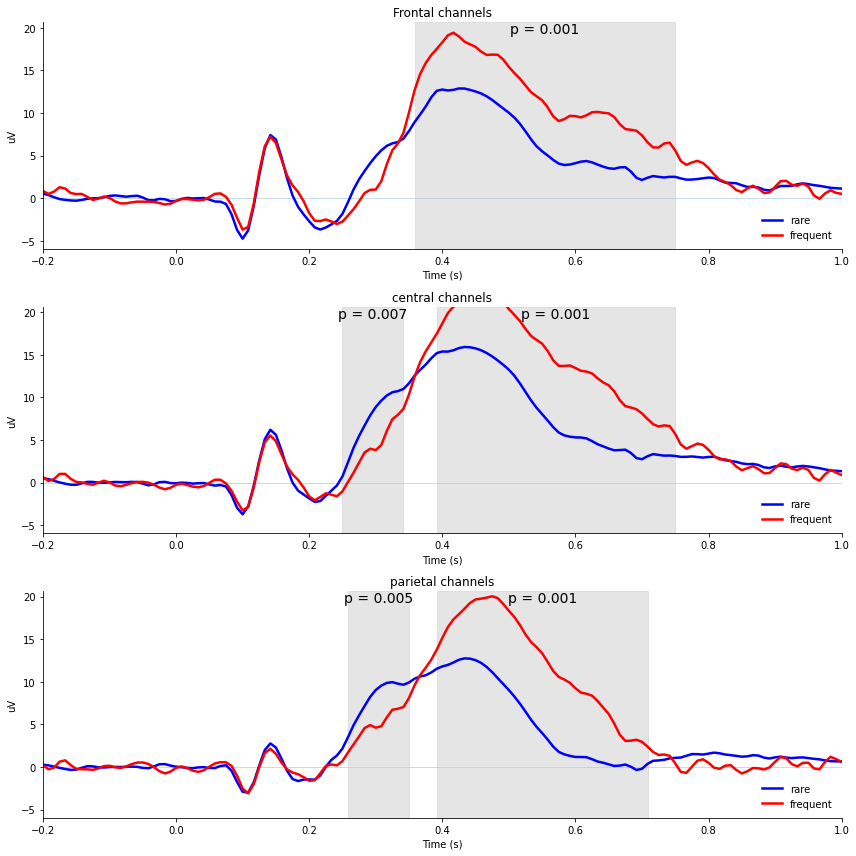

In [38]:
from mne import pick_channels
from mne.stats import permutation_cluster_test

front_rare = np.mean(rare_epochs.copy().pick_channels(frontal).get_data(), axis=1)
central_rare = np.mean(rare_epochs.copy().pick_channels(central).get_data(), axis=1)
parietal_rare = np.mean(rare_epochs.copy().pick_channels(parietal).get_data(), axis=1)

front_freq = np.mean(frequent_epochs.copy().pick_channels(frontal).get_data(), axis=1)
central_freq = np.mean(frequent_epochs.copy().pick_channels(central).get_data(), axis=1)
parietal_freq = np.mean(frequent_epochs.copy().pick_channels(parietal).get_data(), axis=1)

front_F, front_clust, front_pv, front_h0 = permutation_cluster_test([front_rare, front_freq], n_permutations=1024, 
                                                                    seed=47404, tail=1)
central_F, central_clust, central_pv, central_h0 = permutation_cluster_test([central_rare, central_freq], n_permutations=1024, 
                                                                    seed=47404, tail=1)
parietal_F, parietal_clust, parietal_pv, parietal_h0 = permutation_cluster_test([parietal_rare, parietal_freq], n_permutations=1024, 
                                                                    seed=47404, tail=1)

fig, axs = plt.subplots(3,1,figsize=(12,12))

axs[0].plot(rare_epochs.times, np.mean(front_rare, axis=0)*1e6, lw=2.5, label='rare', c='b')
axs[0].plot(rare_epochs.times, np.mean(front_freq, axis=0)*1e6, lw=2.5, label='frequent', c='r')
ymin, ymax = axs[0].get_ylim()
# Plot clusters
for cluster, pval in zip(front_clust, front_pv): 
    if pval < 0.05:
        center = rare_epochs.times[cluster].mean()
        axs[0].fill_between(rare_epochs.times[cluster], ymin, ymax, color='0.8', alpha=0.5)
        axs[0].annotate('p = %0.3f' %pval, (0,0), (center, ymax), ha='center', va='top', fontsize=14)
# Add details
axs[0].hlines(0, rare_epochs.tmin, rare_epochs.tmax, linewidth=0.5, alpha=0.5, zorder=0)
axs[0].set(xlim=(rare_epochs.tmin, rare_epochs.tmax), xlabel='Time (s)', ylim=(ymin, ymax), 
       ylabel='uV', title='Frontal channels')
axs[0].legend(loc=4, frameon=False)

axs[1].plot(rare_epochs.times, np.mean(central_rare, axis=0)*1e6, lw=2.5, label='rare', c='b')
axs[1].plot(rare_epochs.times, np.mean(central_freq, axis=0)*1e6, lw=2.5, label='frequent', c='r')
ymin, ymax = axs[0].get_ylim()
# Plot clusters
for cluster, pval in zip(central_clust, central_pv): 
    if pval < 0.05:
        center = rare_epochs.times[cluster].mean()
        axs[1].fill_between(rare_epochs.times[cluster], ymin, ymax, color='0.8', alpha=0.5)
        axs[1].annotate('p = %0.3f' %pval, (0,0), (center, ymax), ha='center', va='top', fontsize=14)
# Add details
axs[1].hlines(0, rare_epochs.tmin, rare_epochs.tmax, linewidth=0.5, alpha=0.5, zorder=0)
axs[1].set(xlim=(rare_epochs.tmin, rare_epochs.tmax), xlabel='Time (s)', ylim=(ymin, ymax), 
       ylabel='uV', title='central channels')
axs[1].legend(loc=4, frameon=False)

axs[2].plot(rare_epochs.times, np.mean(parietal_rare, axis=0)*1e6, lw=2.5, label='rare', c='b')
axs[2].plot(rare_epochs.times, np.mean(parietal_freq, axis=0)*1e6, lw=2.5, label='frequent', c='r')
ymin, ymax = axs[0].get_ylim()
# Plot clusters
for cluster, pval in zip(parietal_clust, parietal_pv): 
    if pval < 0.05:
        center = rare_epochs.times[cluster].mean()
        axs[2].fill_between(rare_epochs.times[cluster], ymin, ymax, color='0.8', alpha=0.5)
        axs[2].annotate('p = %0.3f' %pval, (0,0), (center, ymax), ha='center', va='top', fontsize=14)
# Add details
axs[2].hlines(0, rare_epochs.tmin, rare_epochs.tmax, linewidth=0.5, alpha=0.5, zorder=0)
axs[2].set(xlim=(rare_epochs.tmin, rare_epochs.tmax), xlabel='Time (s)', ylim=(ymin, ymax), 
       ylabel='uV', title='parietal channels')
axs[2].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

## Part 2

In the previous section, you measured the P300 in response to rare trials. During rare trials, participants need to inhibit a prepotent motor response (i.e. responding as if they saw a frequent trial). The need for motor inhibition is often said to generate a conflict signal. In scalp EEG, conflict signals are detectable as increases in non-phase-locked theta (4-8 Hz) power. In this final section, you will follow the steps as detailed in [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013) to measure the theta signature of conflict in rare trials.

## Step 2a: Spectral Decomposition

With the epochs loaded, you will perform a spectral decomposition on the data to measure the time-frequency content of the data. Following [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013), you will use Morlet wavelet decomposition. 

First you need to define the frequencies you want to measure. Using `np.logspace`, generate a vector of 12 logarithmically-spaced frequencies beginning at 4 Hz and ending at 30 Hz. (Note: If you do this correct, your vector should start and end with 4 and 30, respectively.)

In [40]:
freqs = np.logspace(np.log(4), np.log(30), num=12, base=np.e)

In this next section, you are going to perform the spectral decomposition. The challenge is that you will need to measure non-phase-locked power. In other words, you are decomposing the epochs after the evoked potential has been subtracted. Importantly, this subtraction must occur within each condition. 

To assist you, we have started a for loop. In each cycle of the for loop, you will perform the following steps:

1. Make copy of the per-condition epochs.
2. Subtract evoked potential from copy.
3. Perform Morlet wavelet decomposition on the evoked-subtracted copy using the following parameters:
    - `freqs`: as defined above
    - `n_cycles`: 3
    - `return_itc`: False
4. Apply a baseline transformation to the power estimates making sure to:
    - Baseline correct (-0.1, 0.0)
    - Convert power into decibels.

In [42]:
from mne.time_frequency import tfr_morlet

## Define conditions.
conditions = ['20_Dig_L', '20_Dig_R', '20_Let_L', '20_Let_R',
              '80_Dig_L', '80_Dig_R', '80_Let_L', '80_Let_R']

## Main loop.
spectral = []
for k in conditions:

    ## Make temporary copy.
    trials = epochs[k].copy()
    
    ## Subtract evoked.
    trials.subtract_evoked()
    
    ## Perform Morlet-based time-frequency decomposition.
    decomp = tfr_morlet(trials, freqs, 3, return_itc=False)
    
    ## Apply baseline transformation.
    decomp = decomp.apply_baseline(baseline=(-.1,0), mode='logratio')
    
    ## Store.
    spectral.append(10*decomp.data)
    
## Convert to NumPy array.
spectral = np.array(spectral)

## Step 2b: Compute Averages 

Using the power estimates defined above, create an average spectrogram for the frequent and rare trials.

In [44]:
rare_spec = np.mean(spectral[:4], axis=0)
frequent_spec = np.mean(spectral[4:], axis=0)

## Step 2c: Visualize Spectrograms

#### Frequent Trials

Plot the spectrogram of the frequent trials for channel FCz using your favorite heatmap function.

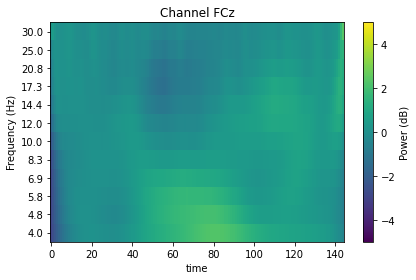

In [62]:
plt.imshow(frequent_spec[epochs.ch_names.index('FCz')], interpolation='None', aspect='auto', origin='lower', vmin=-5, vmax=5)
plt.xlabel('time')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.arange(12), freqs.round(1));
cbar = plt.colorbar()
cbar.set_label('Power (dB)')
plt.title('Channel FCz')
plt.tight_layout()

#### Rare Trials

Plot the spectrogram of the rare trials for channel FCz using your favorite heatmap function.

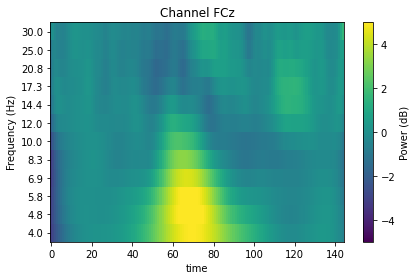

In [61]:
plt.imshow(rare_spec[epochs.ch_names.index('FCz')], interpolation='None', aspect='auto', origin='lower', vmin=-5, vmax=5)
plt.xlabel('time')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.arange(12), freqs.round(1));
cbar = plt.colorbar()
cbar.set_label('Power (dB)')
plt.title('Channel FCz')
plt.tight_layout()

#### Rare - Frequent Trials

Plot the spectrogram of the rare - frequent trials for channel FCz using your favorite heatmap function.

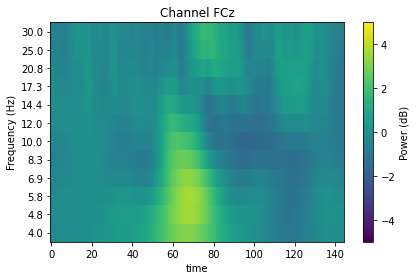

In [63]:
plt.imshow(rare_spec[epochs.ch_names.index('FCz')]-frequent_spec[epochs.ch_names.index('FCz')], interpolation='None', aspect='auto', origin='lower', vmin=-5, vmax=5)
plt.xlabel('time')
plt.ylabel('Frequency (Hz)')
plt.yticks(np.arange(12), freqs.round(1));
cbar = plt.colorbar()
cbar.set_label('Power (dB)')
plt.title('Channel FCz')
plt.tight_layout()

**Q:** Is there an increase in theta power between frequent and rare trials? If so, where?

> &nbsp; There is, starting just before frame 60, which at our sampling rate of 120 Hz is ~450ms.

**Q:** Does the plot above resemble the non-phase-locked power from the midfrontal electrode (FCz) in Figure 2 of [Cohen & Donner (2013)](https://www.physiology.org/doi/full/10.1152/jn.00479.2013)?

> &nbsp; No, ours does not have the negative delta power in the 8-30Hz range that their non-phase-locked power shows.


# Part 3

The final question on this problem set is about experimental design.

You've just received a manuscript for review from an eminent  neuroeconomics researcher who claims to have discovered an ERP that registers when someone learns about a potentially lucrative financial opportunity. You turn a critical eye towards the paper, and see that the results have probably been over-interpreted. 

Here is the design: A computer presented numbers on a screen representing the quantity that may be won or lost on a given trial. If the amount was positive, the numbers were green. If the amount was negative, the numbers were red. The subject was asked to press a button if they wanted to “place a bet”. The cost of a bet was \\$0.01. If the subject chose to place a bet, two seconds after their response they were informed as to whether they won. 80% of the time they won the promised amount, but 20% of the time they won or lost a random amount between -\\$10 and \\$10. The average payout on positive trials was \\$6, and the average loss on negative trials was \\$5. A payout or loss only occurred if the subject placed a bet. To simulate the negative bias of the financial media, only 10% of trials were positive, while 90% were negative. 

The results: Behaviorally, subjects bet on 95% of positive trials and only 1% of negative trials. There is an ERP for the green positive numbers that peaks at about 210 ms over parietal cortex. The stimulus-locked ERP pattern evoked by the colored number looks like this: 

![](images/part3-figure.png)

(Note that negative voltages are plotted here as positive on the Y axis as per traditional practice -- and that's not a mistake or a confound.) 


**Q:** Name at least two possible confounds with this experiment. (One extra-credit point can be earned by naming three confounds.)

> &nbsp; Okay assuming you mean that this plot is what they are using to convey their "discovery" then the major confound is just that we're looking at an ERP for positive numbers which are perfectly correlated with color, so we cannot distinguish a neural green/red response from a neural positive/negative response. Secondly, based on your phrasing it is unclear if this is even meant to convey anything about their betting or the unexpectedness of their reward, but given the proportions listed, trials in which the subjects bet are ~10:1 positive:negative. This also means that any result from looking at neural response to positive bet results will be confounded with trial positivity, and therefore once again with color. Finally, and most relevantly, because positive:negative trials (regardless of betting) are 10:1, one would expect to see a P300, as the positivity correlates with trial-type frequency. Positive trials are less expected, so the exact ERP they see is likely reflecting a P300, though a little early.